# TP1 : First order methods on regression models

#### Authors: A. Gramfort, R. Gower

## Aim

The aim of this material is to code 
- proximal gradient descent (ISTA)
- accelerated gradient descent (FISTA) 

for 
- linear regression
- logistic regression 

models.

The proximal operators we will use are the 
- ridge penalization
- L1 penalization

## VERY IMPORTANT

- This work **must be done by pairs of students**.
- **Each** student must send their work **before the 8th of october at 23:59**, using the **moodle platform**.
- This means that **each student in the pair sends the same file**
- On the moodle, in the "Optimization for Data Science" course, you have a "devoir" section called **Rendu TP du 2 octobre 2017**. This is where you submit your jupyter notebook file. 
- The **name of the file must be** constructed as in the next cell

# Gentle reminder: no evaluation if you don't respect this EXACTLY

### How to construct the name of your file

In [1]:
# Change here using YOUR first and last names
fn1 = "oumayma"
ln1 = "bounou"
fn2 = "guillaume"
ln2 = "leveque"

filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["tp1", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

tp1_bounou_oumayma_and_leveque_guillaume.ipynb


In [2]:
## to embed figures in the notebook
%matplotlib inline

## Part 0 : Introduction

We'll start by generating sparse vectors and simulating data

### Getting sparse coefficients

In [3]:
import numpy as np
import matplotlib.pyplot as plt

np.set_printoptions(precision=2)  # to have simpler print outputs with numpy

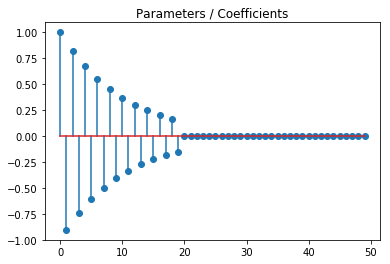

In [4]:
n_features = 50
n_samples = 1000
idx = np.arange(n_features)
coefs = ((-1) ** idx) * np.exp(-idx / 10.)
coefs[20:] = 0.
plt.stem(coefs)
plt.title("Parameters / Coefficients")

### Functions for the simulation of the models

In [5]:
from numpy.random import multivariate_normal
from scipy.linalg.special_matrices import toeplitz
from numpy.random import randn


def simu_linreg(coefs, n_samples=1000, corr=0.5):
    """Simulation of a linear regression model
    
    Parameters
    ----------
    coefs : `numpy.array`, shape=(n_features,)
        Coefficients of the model
    
    n_samples : `int`, default=1000
        Number of samples to simulate
    
    corr : `float`, default=0.5
        Correlation of the features

    Returns
    -------
    A : `numpy.ndarray`, shape=(n_samples, n_features)
        Simulated features matrix. It samples of a centered Gaussian 
        vector with covariance given by the Toeplitz matrix
    
    b : `numpy.array`, shape=(n_samples,)
        Simulated labels
    """
    # Construction of a covariance matrix
    cov = toeplitz(corr ** np.arange(0, n_features))
    # Simulation of features
    A = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    # Simulation of the labels
    b = A.dot(coefs) + randn(n_samples)
    return A, b


def sigmoid(t):
    """Sigmoid function"""
    return 1. / (1. + np.exp(-t))


def simu_logreg(coefs, n_samples=1000, corr=0.5):
    """Simulation of a logistic regression model
    
    Parameters
    ----------
    coefs : `numpy.array`, shape=(n_features,)
        Coefficients of the model
    
    n_samples : `int`, default=1000
        Number of samples to simulate
    
    corr : `float`, default=0.5
        Correlation of the features

    Returns
    -------
    A : `numpy.ndarray`, shape=(n_samples, n_features)
        Simulated features matrix. It samples of a centered Gaussian 
        vector with covariance given by the Toeplitz matrix
    
    b : `numpy.array`, shape=(n_samples,)
        Simulated labels
    """
    cov = toeplitz(corr ** np.arange(0, n_features))
    A = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    p = sigmoid(A.dot(coefs))
    b = np.random.binomial(1, p, size=n_samples)
    b[:] = 2 * b - 1
    return A, b

## Part 1 : Proximal operators

We remind that the proximal operator of a fonction $g$ is given by:

$$
\text{prox}_g(y, t) = \arg\min_x \Big\{ \frac 12 \|x - y\|_2^2 + t g(x) \Big\}.
$$

where $t \geq 0$ is a non-negative number.
We have in mind to use the following cases

- Ridge penalization, where $g(x) = \frac{s}{2} \|x\|_2^2$
- Lasso penalization, where $g(x) = s \|x\|_1$

where $s \geq 0$ is a regularization parameter.

## Questions

- Code a function that computes $g(x)$ in both cases and $\text{prox}_g(x)$ for ridge and  lasso penalization (use the slides of the first course to get the formulas), using the prototypes given below
- Visualize the functions applied element wise by the proximity operators of the Ridge and Lasso 

In [6]:
def prox_lasso(x, s, t=1.):
    """Proximal operator for the Lasso at x with strength t"""    
    prox = []
    for i in range (len(x)):
    #return x # TODO
        if (x[i]<-s):
            prox.append(x[i]+s)
        elif (x[i]>s):
            prox.append(x[i]-s)        
        else:
            prox.append(0)
        i=i+1  
    return np.asarray(prox)
    
def lasso(x, s):
    return s*np.linalg.norm(x,1)
    """Value of the Lasso penalization at x with strength t"""

def prox_ridge(x, s, t=1.):
    """Proximal operator for the ridge at x with strength t"""    
    #return x # TODO
    prox=[]
    for i in range(len(x)):
        prox.append(x[i]/float(s+1))
    return np.asarray(prox)


def ridge(x, s):
    """Value of the ridge penalization at x with strength t"""
    return s/float(2)*np.linalg.norm(x,2)**2

## Visualization

We are now going to visualize the effect of the proximity operators on coefficients.

(-2, 2)

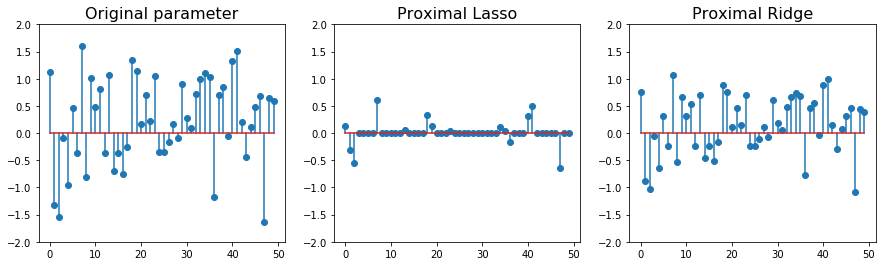

In [7]:
x = randn(50)
l_l1 = 1.
l_l2 = 0.5

plt.figure(figsize=(15.0, 4.0))
plt.subplot(1, 3, 1)
plt.stem(x)
plt.title("Original parameter", fontsize=16)
plt.ylim([-2, 2])
plt.subplot(1, 3, 2)
plt.stem(prox_lasso(x, s=l_l1))
plt.title("Proximal Lasso", fontsize=16)
plt.ylim([-2, 2])
plt.subplot(1, 3, 3)
plt.stem(prox_ridge(x, s=l_l2))
plt.title("Proximal Ridge", fontsize=16)
plt.ylim([-2, 2])

## Question

- Comment what you observe (1 or 2 sentences).

## The proximal operator for the Lasso penalization only keeps certain coefficients/features based on their difference with s. 
## The proximal operator for the Ridge penalization multpliplies their value by a constant.

## Part 2: Gradients

The problems we want to minimize take the form:
$$
\arg\min_x f(x) + g(x)
$$
where $f$ is $L$-smooth and $g$ is prox-capable.

We will consider below the following cases

**Linear regression**, where 
$$
f(x) = \frac{1}{2n} \sum_{i=1}^n (b_i - a_i^\top x)^2 = \frac{1}{2 n} \| b - A x \|_2^2,
$$
where $n$ is the sample size, $b = [b_1 \cdots b_n]$ is the vector of labels and $A$ is the matrix of features.

**Logistic regression**, where
$$
f(x) = \frac{1}{n} \sum_{i=1}^n \log(1 + \exp(-b_i a_i^\top x)),
$$
where $n$ is the sample size, and where labels $b_i \in \{ -1, 1 \}$ for all $i$.

We need to be able to compute $f$ and its gradient

**Questions**:
- Compute on paper the gradient $\nabla f$ of $f$ for both cases (linear and logistic regression)
- Code a function that computes $f$ and its gradient $\nabla f$ in both cases, using the prototypes below.
- Check that these functions are correct by numerically checking the gradient, using the function ``checkgrad`` from ``scipy.optimize``. Remark: use the functions `simu_linreg` and `simu_logreg` to simulate data according to the right model

In [8]:
#Simulate A and b for both linear and logistic models
A_lin, b_lin = simu_linreg(coefs, n_samples=1000, corr=0.5)
A_log, b_log = simu_logreg(coefs, n_samples=1000, corr=0.5)

In [9]:
def loss_linreg(x,A=A_lin,b=b_lin):
    """Least-squares loss"""
    # TODO
    #pass
    n = len(x)
    return (1./(2*n))*np.linalg.norm(np.dot(A,x)-b,2)**2

def grad_linreg(x,A=A_lin,b=b_lin):
    """Least-squares gradient"""
    # TODO
    #pass
    n = len(x)
    return (1./n)*np.dot(A.T,np.dot(A,x)-b)

def loss_logreg(x,A=A_log,b=b_log):
    n=len(x)
    loss_logreg = 0
    for i in range(n):
        loss_logreg = loss_logreg + 1./n*np.log(1+np.exp(-b[i]*np.dot(A[i].T,x)))
        i=i+1
    return loss_logreg
    """Logistic loss"""
    # TODO
    #pass
    return 

def grad_logreg(x,A=A_log,b=b_log):
    """Logistic gradient"""
    # TODO
    #pass
    grad_logreg=0
    n=len(x)
    for i in range(n):
        grad_logreg = grad_logreg - 1./n*(b[i]*A[i]*np.exp(-b[i]*np.dot(A[i].T,x))/(1 + np.exp(-b[i]*np.dot(A[i].T,x))))
        i=i+1
    return grad_logreg

# TO BE COMPLETED

In [10]:
from scipy.optimize import check_grad
x = randn(A_lin.shape[1])
check_grad(loss_linreg,grad_linreg,x)

8.177373899065333e-05

In [11]:
from scipy.optimize import check_grad
x = randn(A_log.shape[1])
check_grad(loss_logreg,grad_logreg,x)

3.1057298791906833e-07

## Part 3: Solvers

We now have a function to compute $f$, $\nabla f$ and $g$ and $\text{prox}_g$. 

We want now to code the Ista and Fista solvers to minimize

$$
\arg\min_x f(x) + g(x)
$$

**Questions**:

- Implement functions that compute the Lipschitz constants for linear and 
  logistic regression losses. Note that the operator norm of a matrix can 
  be computed using the function `numpy.linalg.norm` (read the documentation
  of the function)

- Finish the functions `ista` and `fista` below that implements the 
  ISTA (Proximal Gradient Descent) and FISTA (Accelerated Proximal 
  Gradient Descent) algorithms

In [12]:
def lip_linreg(A=A_lin):
    """Lipschitz constant for linear squares loss"""    
    # TODO
    #pass
    n=A.shape[1]
    return 1./n*np.linalg.norm(A.T.dot(A),2)
    
def lip_logreg(A=A_log,b=b_log):
    """Lipschitz constant for logistic loss"""    
    # TODO
    #pass
    n=A.shape[1]
    lip_logreg = 0
    for i in range(n):
        lip_logreg = lip_logreg + 1./n*b[i]**2*np.linalg.norm(A[i],2)**2
        i=i+1
    return lip_logreg
    
def ista(x0, f, grad_f, g, prox_g, step, A, b, s=0., n_iter=50,
         x_true=coefs, verbose=True):
    """Proximal gradient descent algorithm
    """
    x = x0.copy()
    x_new = x0.copy()
    n_samples, n_features = A.shape
    obj_true = f(x_true) + g(x_true, s)

    # estimation error history
    errors = []
    # Minimum estimation error history
    min_errors = []
    # objective history
    objectives = []
    # Current estimation error
    err = np.linalg.norm(x - x_true) / np.linalg.norm(x_true)
    errors.append(err)
    # Current objective
    obj = f(x) + g(x, s)
    # Current minimum estimation error    
    min_err = (obj-obj_true)/obj_true
    min_errors.append(min_err)
    objectives.append(obj)
    if verbose:
        print("Lauching ISTA solver...")
        print(' | '.join([name.center(8) for name in ["it", "obj", "err"]]))
    for k in range(n_iter + 1):

        #### TODO ####
        
        x = prox_g(x-step*grad_f(x,A,b),s,t=1.)
        obj = f(x) + g(x, s)
        err = np.linalg.norm(x - x_true) / np.linalg.norm(x_true)
        min_err = np.abs(obj-obj_true)/(obj_true)
        min_errors.append(min_err)
        errors.append(err)
        objectives.append(obj)
        if k % 10 == 0 and verbose:
            print(' | '.join([("%d" % k).rjust(8), 
                              ("%.2e" % obj).rjust(8), 
                              ("%.2e" % err).rjust(8)]))
    return x, objectives, errors,min_errors

In [13]:
def fista(x0, f, grad_f, g, prox_g, step, A,b, s=0., n_iter=50,
         x_true=coefs, verbose=False):
    """Accelerated Proximal gradient descent algorithm
    """
    x = x0.copy()
    x_new = x0.copy()
    obj_true = f(x_true) + g(x_true, s)
    # An extra variable is required for FISTA
    z = x0.copy()
    beta=1
    n_samples, n_features = A.shape
    # estimation error history
    errors = []
    # Minimum estimation error history
    min_errors = []
    # objective history
    objectives = []
    # Current estimation error
    err = np.linalg.norm(x - x_true) / np.linalg.norm(x_true)
    errors.append(err)
    # Current objective
    obj = f(x) + g(x, s)
    objectives.append(obj)
    # Current minimum estimation error    
    min_err = (obj-obj_true)/obj_true
    min_errors.append(min_err)
    t = 1.
    t_new = 1.    
    if verbose:
        print("Launching FISTA solver...")
        print(' | '.join([name.center(8) for name in ["it", "obj", "err"]]))
    for k in range(n_iter + 1):

        #### TODO ####
        
        
        t_new = (1+np.sqrt(1+4*t**2))/float(2)
        x_new = prox_g(z-step*grad_f(x,A,b),s,t=1.)
        z_new = x_new + (t-1)/t_new*(x_new-x)
        t = t_new
        x = x_new
        z = z_new
        
        obj = f(x) + g(x, s)
        err = np.linalg.norm(x - x_true) / np.linalg.norm(x_true)
        min_err = (obj-obj_true)/obj_true
        errors.append(err)
        objectives.append(obj)
        min_errors.append(min_err)
        if k % 10 == 0 and verbose:
            print(' | '.join([("%d" % k).rjust(8), 
                              ("%.2e" % obj).rjust(8), 
                              ("%.2e" % err).rjust(8)]))
    return x, objectives, errors, min_errors

## Algorithms comparison and numerical experiments

In [14]:
# Some definitions before launching the algorithms
x0 = np.zeros(n_features)
n_iter = 1000
s = 1e-2

**Questions**

- Compute a precise minimum and a precise minimizer of the linear regression with ridge 
  penalization problem using the parameters give above. This can be done by using FISTA with 
  1000 iterations.
- Compare the convergences of ISTA and FISTA, in terms of distance to the minimum and 
  distance to the minimizer. Do your plots using a logarithmic scale of the y-axis.

#### ISTA and FISTA for linear regression

In [15]:
#### ISTA Test with linear regression and ridge penalization
x_ista, objectives_ista, errors_ista, min_errors_ista = ista(
    x0=x0,f=loss_linreg,grad_f=grad_linreg,
    step=1./lip_linreg(A=A_lin),g=ridge,prox_g=prox_ridge,s=s,n_iter=n_iter,
    x_true=coefs,A=A_lin,b=b_lin,verbose=False)

#### FISTA Test with linear regression and ridge penalization
x_fista, objectives_fista, errors_fista, min_errors_fista = fista(
    x0=x0,f=loss_linreg,grad_f=grad_linreg,
    step=1./lip_linreg(A=A_lin),g=ridge,prox_g=prox_ridge,s=s,n_iter=n_iter,
    x_true=coefs,A=A_lin,b=b_lin, verbose=False)

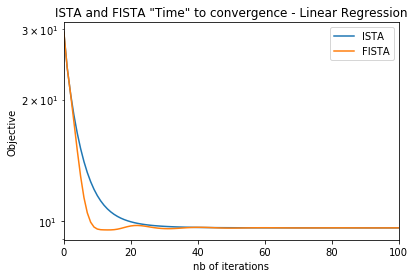

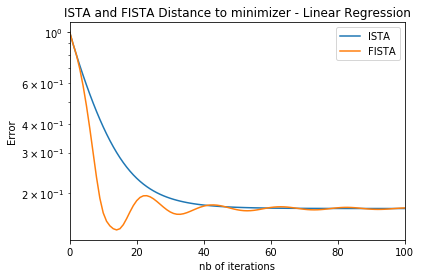

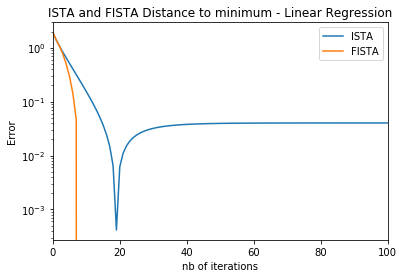

In [16]:
import math

plt.figure()
plt.plot([x for x in range(n_iter+2)],[y for y in objectives_ista],label='ISTA')
plt.xlabel('nb of iterations')
plt.ylabel('Objective')
plt.title('ISTA and FISTA "Time" to convergence - Linear Regression')
plt.plot([x for x in range(n_iter+2)],[y for y in objectives_fista],label='FISTA')
plt.legend()
plt.xlim([0,100])
plt.yscale('log')

plt.figure()
plt.plot([x for x in range(n_iter+2)],[y for y in errors_ista],label='ISTA')
plt.xlabel('nb of iterations')
plt.ylabel('Error')
plt.title('ISTA and FISTA Distance to minimizer - Linear Regression')
plt.plot([x for x in range(n_iter+2)],[y for y in errors_fista],label='FISTA')
plt.legend()
plt.xlim([0,100])
plt.yscale('log')


plt.figure()
plt.plot([x for x in range(n_iter+2)],[y for y in min_errors_ista],label='ISTA')
plt.xlabel('nb of iterations')
plt.ylabel('Error')
plt.title('ISTA and FISTA Distance to minimum - Linear Regression')
plt.plot([x for x in range(n_iter+2)],[y for y in min_errors_fista],label='FISTA')
plt.legend()
plt.xlim([0,100])
plt.yscale('log')


plt.show()

In [18]:
len(objectives_fista), n_iter + 2

(1002, 1002)

#### ISTA and FISTA for logisitic regression

In [259]:
#### ISTA Test with logistic regression and ridge penalization
x_ista, objectives_ista, errors_ista, min_errors_ista = ista(
    x0=x0,f=loss_logreg,grad_f=grad_logreg,
    step=1./lip_logreg(A=A_log,b=b_log),g=ridge,prox_g=prox_ridge,s=s,n_iter=n_iter,
    x_true=coefs,A=A_log,b=b_log,verbose=False)

#### FISTA Test with logistic regression and ridge penalization
x_fista, objectives_fista, errors_fista, min_errors_fista = fista(
    x0=x0,f=loss_logreg,grad_f=grad_logreg,
    step=1./lip_logreg(A=A_log,b=b_log),g=ridge,prox_g=prox_ridge,s=s,n_iter=n_iter,
    x_true=coefs,A=A_log,b=b_log, verbose=False)

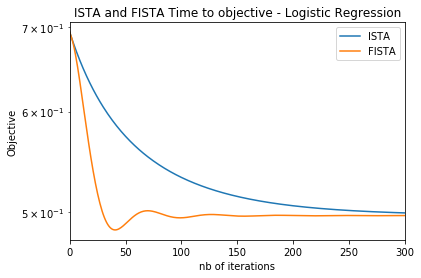

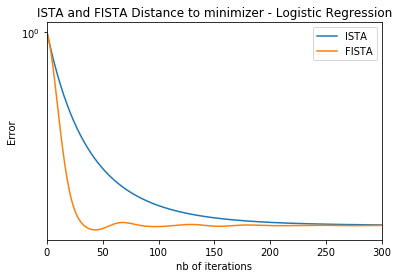

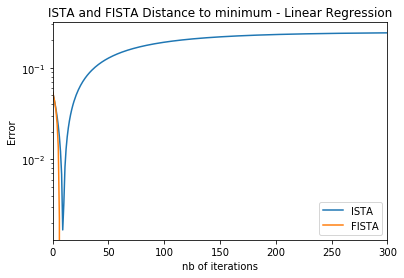

In [263]:
import math

plt.figure()
plt.plot([x for x in range(n_iter+2)],[y for y in objectives_ista],label='ISTA')
plt.xlabel('nb of iterations')
plt.ylabel('Objective')
plt.title('ISTA and FISTA Time to objective - Logistic Regression')
plt.plot([x for x in range(n_iter+2)],[y for y in objectives_fista],label='FISTA')
plt.legend()
plt.xlim([0,300])
plt.yscale('log')


plt.figure()
plt.plot([x for x in range(n_iter+2)],[y for y in errors_ista],label='ISTA')
plt.xlabel('nb of iterations')
plt.ylabel('Error')
plt.title('ISTA and FISTA Distance to minimizer - Logistic Regression')
plt.plot([x for x in range(n_iter+2)],[y for y in errors_fista],label='FISTA')
plt.legend()
plt.xlim([0,300])
plt.yscale('log')


plt.figure()
plt.plot([x for x in range(n_iter+2)],[y for y in min_errors_ista],label='ISTA')
plt.xlabel('nb of iterations')
plt.ylabel('Error')
plt.title('ISTA and FISTA Distance to minimum - Linear Regression')
plt.plot([x for x in range(n_iter+2)],[y for y in min_errors_fista],label='FISTA')
plt.legend()
plt.xlim([0,300])
plt.yscale('log')

plt.show()

In [ ]:
min_e

### We notice that for both regressions, the minimum is reached sooner when using FISTA instead of ISTA.

**Questions**

- In linear regression and logistic regression, study the influence of the correlation 
  of the features on the performance of the optimization algorithms. Explain.

- In linear regression and logistic regression, study the influence of the level of ridge 
  penalization on the performance of the optimization algorithms. Explain.

- In linear regression and logistic regression, compare the performance of the optimization
  algorithms for ridge and lasso penalizations. Explain

### Influence of features correlation

#### FISTA linear regression

/Users/Oumayma/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: covariance is not positive-semidefinite.


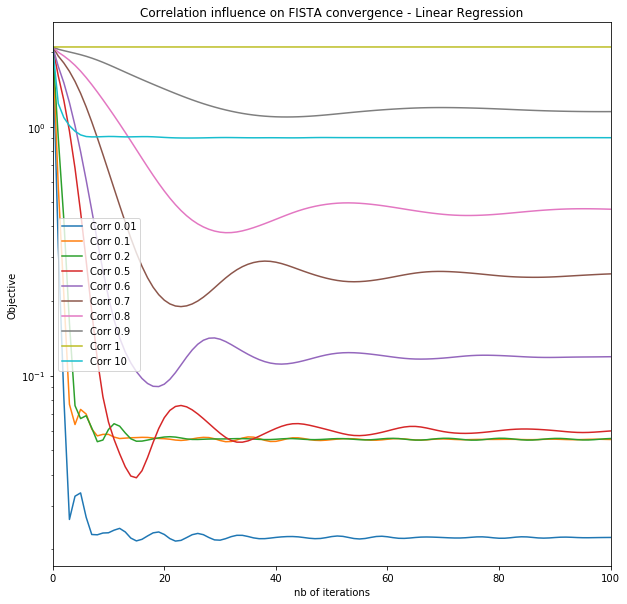

In [264]:
corr = [0.01,0.1,0.2,0.5,0.6,0.7,0.8,0.9,1,10]
A_lin_list = []
b_lin_list = []
objectives_fista_list = []
errors_fista_list = []
min_errors_fista_list = []

plt.figure(figsize=(10,10))
for i in range (len(corr)):
    A_lin, b_lin = simu_linreg(coefs=coefs,n_samples=1000,corr=corr[i])
    x_fista, objectives_fista, errors_fista, min_errors_fista = fista(
    x0=x0,f=loss_linreg,grad_f=grad_linreg,
    step=1./lip_linreg(A=A_lin),g=ridge,prox_g=prox_ridge,s=s,n_iter=n_iter,
    x_true=coefs,A=A_lin,b=b_lin, verbose=False)
    A_lin_list.append(A_lin)
    b_lin_list.append(b_lin)
    objectives_fista_list.append(objectives_fista)
    errors_fista_list.append(errors_fista)
    min_errors_fista_list.append(min_errors_fista)
    
    #plt.figure()
    #plt.plot([x for x in range(n_iter+2)],[y for y in objectives_fista] )
    plt.xlabel('nb of iterations')
    plt.ylabel('Objective')
    plt.title('Correlation influence on FISTA convergence - Linear Regression'.format(corr[i]))
    plt.plot([x for x in range(n_iter+2)],[y for y in min_errors_fista],label='Corr {0}'.format(corr[i]))
    plt.legend()
    plt.xlim([0,100])
    plt.yscale('log')


### We notice that the slower the value of corr, the faster FISTA converges, which is not surprising since we know that the more our features are correlated, the less "independent" information they hold, and the less performant our algorithm will be. 
### We also notice that for corr>=0.6, the distance to the minimum is not zero (and will probably never be).

### Let's verify that the same holds for ISTA with a linear regression 

#### ISTA Linear Regression

/Users/Oumayma/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: covariance is not positive-semidefinite.


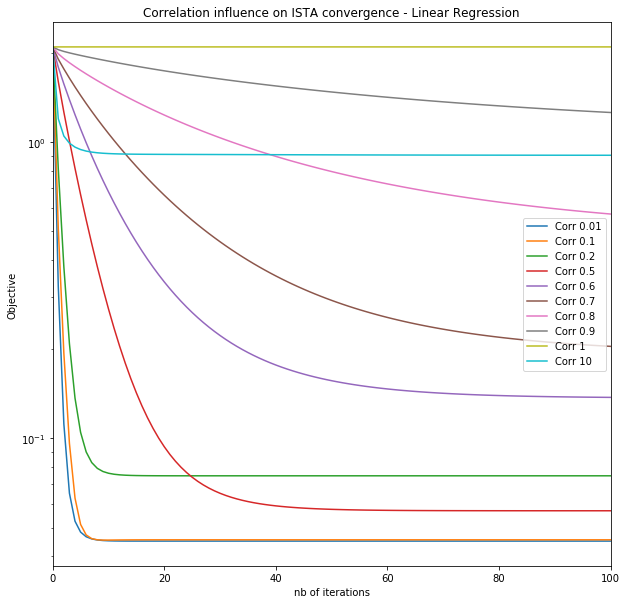

In [266]:
corr = [0.01,0.1,0.2,0.5,0.6,0.7,0.8,0.9,1,10]
A_lin_list = []
b_lin_list = []
objectives_ista_list = []
errors_ista_list = []
min_errors_ista_list = []

plt.figure(figsize=(10,10))
for i in range (len(corr)):
    A_lin, b_lin = simu_linreg(coefs=coefs,n_samples=1000,corr=corr[i])
    x_ista, objectives_ista, errors_ista, min_errors_ista = ista(
    x0=x0,f=loss_linreg,grad_f=grad_linreg,
    step=1./lip_linreg(A=A_lin),g=ridge,prox_g=prox_ridge,s=s,n_iter=n_iter,
    x_true=coefs,A=A_lin,b=b_lin, verbose=False)
    A_lin_list.append(A_lin)
    b_lin_list.append(b_lin)
    objectives_ista_list.append(objectives_ista)
    errors_ista_list.append(errors_ista)
    min_errors_ista_list.append(min_errors_ista)
    
    #plt.figure()
    plt.xlabel('nb of iterations')
    plt.ylabel('Objective')
    plt.title('Correlation influence on ISTA convergence - Linear Regression'.format(corr[i]))
    plt.plot([x for x in range(n_iter+2)],[y for y in min_errors_ista],label='Corr {0}'.format(corr[i]))
    plt.legend()
    plt.xlim([0,100])
    plt.yscale('log')    

### It's the same thing for ISTA. 

#### FISTA logistic regression

/Users/Oumayma/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: covariance is not positive-semidefinite.
/Users/Oumayma/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: overflow encountered in exp


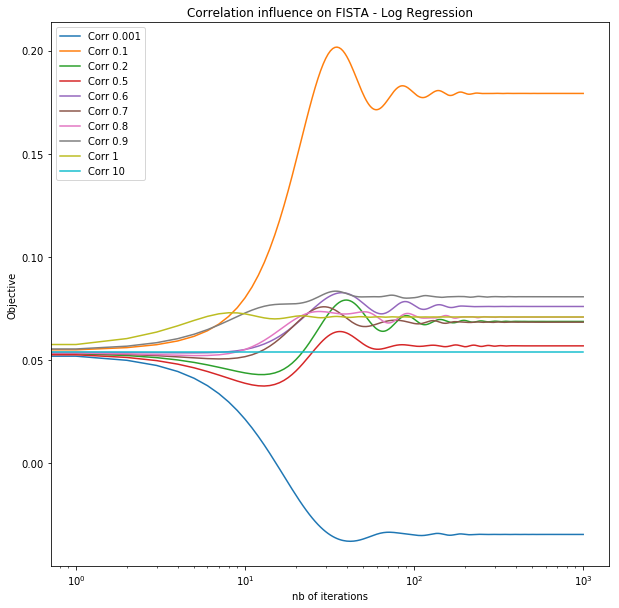

In [267]:
corr = [0.001,0.1,0.2,0.5,0.6,0.7,0.8,0.9,1,10]
A_log_list = []
b_log_list = []
objectives_fista_list = []
errors_fista_list = []
min_errors_fista_list = []

plt.figure(figsize=(10,10))
for i in range (len(corr)):
    A_log, b_log = simu_logreg(coefs=coefs,n_samples=1000,corr=corr[i])
    x_fista, objectives_fista, errors_fista, min_errors_fista = fista(
    x0=x0,f=loss_logreg,grad_f=grad_logreg,
    step=1./lip_logreg(A=A_log,b=b_log),g=ridge,prox_g=prox_ridge,s=s,n_iter=n_iter,
    x_true=coefs,A=A_log,b=b_log, verbose=False)
    A_log_list.append(A_log)
    b_log_list.append(b_log)
    objectives_fista_list.append(objectives_fista)
    errors_fista_list.append(errors_fista)
    min_errors_fista_list.append(min_errors_fista)
    
    #plt.figure()
    plt.xlabel('nb of iterations')
    plt.ylabel('Objective')
    plt.title('Correlation influence on FISTA - Log Regression'.format(corr[i]))
    plt.plot([x for x in range(n_iter+2)],[y for y in min_errors_fista],label='Corr {0}'.format(corr[i]))
    plt.legend()
    plt.xscale('log')
    

#### ISTA logistic regression

/Users/Oumayma/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: covariance is not positive-semidefinite.
/Users/Oumayma/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: overflow encountered in exp


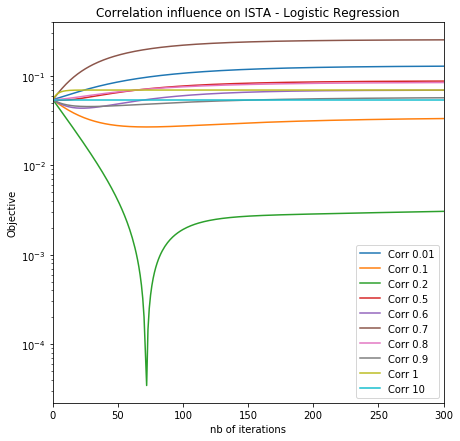

In [270]:
corr = [0.01,0.1,0.2,0.5,0.6,0.7,0.8,0.9,1,10]
A_log_list = []
b_log_list = []
objectives_ista_list = []
errors_ista_list = []
min_errors_ista_list = []

plt.figure(figsize=(7,7))
for i in range (len(corr)):
    A_log, b_log = simu_logreg(coefs=coefs,n_samples=1000,corr=corr[i])
    x_ista, objectives_ista, errors_ista, min_errors_ista = ista(
    x0=x0,f=loss_logreg,grad_f=grad_logreg,
    step=1./lip_logreg(A=A_log,b=b_log),g=ridge,prox_g=prox_ridge,s=s,n_iter=n_iter,
    x_true=coefs,A=A_log,b=b_log, verbose=False)
    A_log_list.append(A_log)
    b_log_list.append(b_log)
    objectives_ista_list.append(objectives_ista)
    errors_ista_list.append(errors_ista)
    min_errors_ista_list.append(min_errors_ista)
    
    #plt.figure()
    plt.xlabel('nb of iterations')
    plt.ylabel('Objective')
    plt.title('Correlation influence on ISTA Convergence - Logistic Regression'.format(corr[i]))
    plt.plot([x for x in range(n_iter+2)],[y for y in min_errors_ista],label='Corr {0}'.format(corr[i]))
    plt.legend()
    plt.xlim([0,300])
    plt.yscale('log')
    

The correlation coefficient should have the same effect on the logistic regression, though it's' not as obvious as it should be on the plot.

### Influence of the level of ridge penalization

#### ISTA Linear Regression

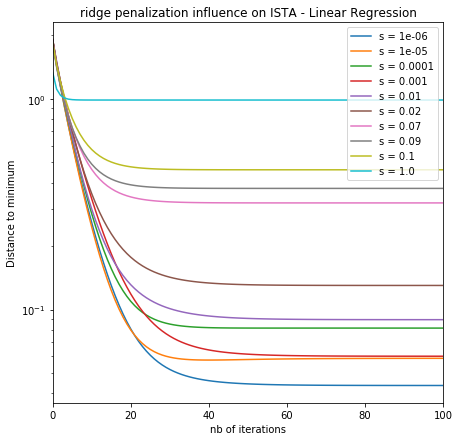

In [235]:
s_list = [1e-6,1e-5,1e-4,1e-3,1e-2,0.02,0.07,0.09,0.1,1e0]
A_lin_list = []
b_lin_list = []
objectives_ista_list = []
errors_ista_list = []
min_errors_ista_list = []

plt.figure(figsize=(7,7))
for i in range (len(s_list)):
    A_lin, b_lin = simu_linreg(coefs=coefs,n_samples=1000,corr=0.5)
    x_ista, objectives_ista, errors_ista, min_errors_ista = ista(
    x0=x0,f=loss_linreg,grad_f=grad_linreg,
    step=1./lip_linreg(A=A_lin),g=ridge,prox_g=prox_ridge,s=s_list[i],n_iter=n_iter,
    x_true=coefs,A=A_lin,b=b_lin, verbose=False)
    A_lin_list.append(A_lin)
    b_lin_list.append(b_lin)
    objectives_ista_list.append(objectives_ista)
    errors_ista_list.append(errors_ista)
    min_errors_ista_list.append(min_errors_ista)
    
    #plt.figure()
    plt.xlabel('nb of iterations')
    plt.ylabel('Distance to minimum')
    plt.title('ridge penalization influence on ISTA - Linear Regression')
    plt.plot([x for x in range(n_iter+2)],[y for y in min_errors_ista],label='s = {0}'.format(s_list[i]))
    plt.legend()
    plt.xlim([0,100])
    plt.yscale('log')
    

### We notice that the more s becomes higher than 0.01, the more the distance to the minimum is important. It makes sense considering that s gets multiplied by a quadratic term in the optimization problem.

### Let's verify that it's the same for FISTA.

#### FISTA Linear Regression

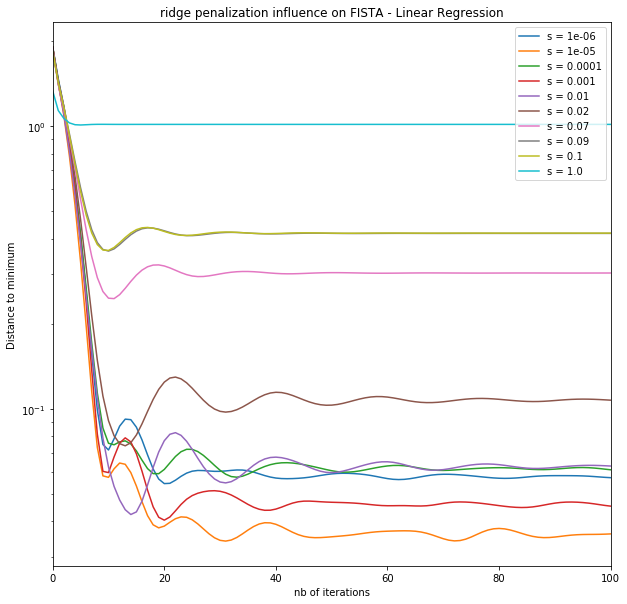

In [236]:
s_list = [1e-6,1e-5,1e-4,1e-3,1e-2,0.02,0.07,0.09,0.1,1e0]
A_lin_list = []
b_lin_list = []
objectives_fista_list = []
errors_fista_list = []
min_errors_fista_list = []

plt.figure(figsize=(10,10))
for i in range (len(s_list)):
    A_lin, b_lin = simu_linreg(coefs=coefs,n_samples=1000,corr=0.5)
    x_fista, objectives_fista, errors_fista, min_errors_fista = fista(
    x0=x0,f=loss_linreg,grad_f=grad_linreg,
    step=1./lip_linreg(A=A_lin),g=ridge,prox_g=prox_ridge,s=s_list[i],n_iter=n_iter,
    x_true=coefs,A=A_lin,b=b_lin, verbose=False)
    A_lin_list.append(A_lin)
    b_lin_list.append(b_lin)
    objectives_fista_list.append(objectives_fista)
    errors_fista_list.append(errors_fista)
    min_errors_fista_list.append(min_errors_fista)
    
    #plt.figure()
    plt.xlabel('nb of iterations')
    plt.ylabel('Distance to minimum')
    plt.title('ridge penalization influence on FISTA - Linear Regression')
    plt.plot([x for x in range(n_iter+2)],[y for y in min_errors_fista],label='s = {0}'.format(s_list[i]))
    plt.legend()
    plt.xlim([0,100])
    plt.yscale('log')
    

### The same holds for FISTA. Let's now see the influence of s on Logistic Regression.

#### ISTA Logistic Regression

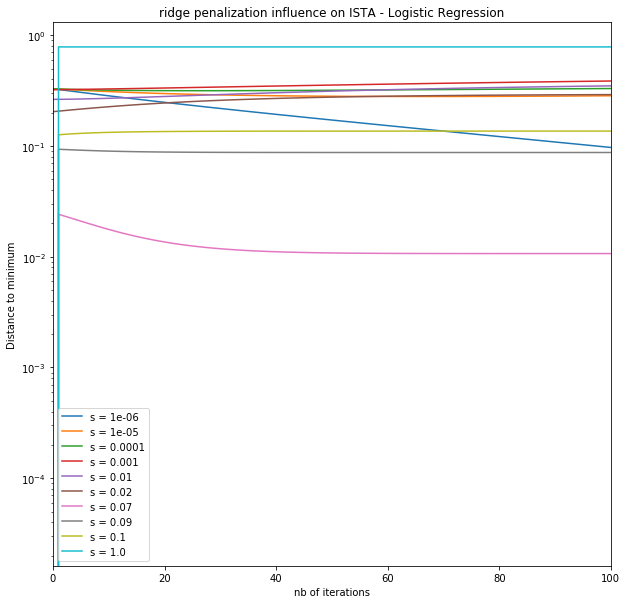

In [237]:
s_list = [1e-6,1e-5,1e-4,1e-3,1e-2,0.02,0.07,0.09,0.1,1e0]
A_log_list = []
b_log_list = []
objectives_ista_list = []
errors_ista_list = []
min_errors_ista_list = []

plt.figure(figsize=(10,10))
for i in range (len(s_list)):
    A_log, b_log = simu_logreg(coefs=coefs,n_samples=1000,corr=0.5)
    x_ista, objectives_ista, errors_ista, min_errors_ista = ista(
    x0=x0,f=loss_logreg,grad_f=grad_logreg,
    step=1./lip_logreg(A=A_log,b=b_log),g=ridge,prox_g=prox_ridge,s=s_list[i],n_iter=n_iter,
    x_true=coefs,A=A_log,b=b_log, verbose=False)
    A_log_list.append(A_log)
    b_log_list.append(b_log)
    objectives_ista_list.append(objectives_ista)
    errors_ista_list.append(errors_ista)
    min_errors_ista_list.append(min_errors_ista)
    
    #plt.figure()
    plt.xlabel('nb of iterations')
    plt.ylabel('Distance to minimum')
    plt.title('ridge penalization influence on ISTA - Logistic Regression')
    plt.plot([x for x in range(n_iter+2)],[y for y in min_errors_ista],label='s = {0}'.format(s_list[i]))
    plt.legend()
    plt.xlim([0,100])
    plt.yscale('log')
    

#### FISTA logistic regression

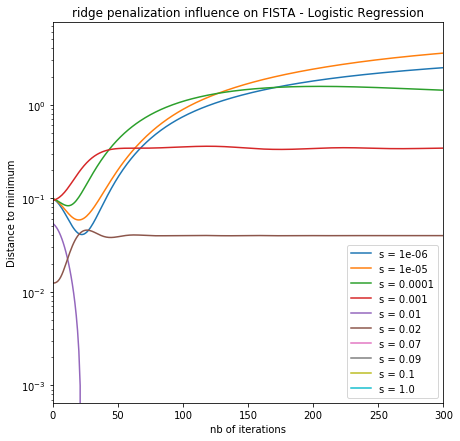

In [271]:
s_list = [1e-6,1e-5,1e-4,1e-3,1e-2,0.02,0.07,0.09,0.1,1e0]
A_log_list = []
b_log_list = []
objectives_fista_list = []
errors_fista_list = []
min_errors_fista_list = []

plt.figure(figsize=(7,7))
for i in range (len(s_list)):
    A_log, b_log = simu_logreg(coefs=coefs,n_samples=1000,corr=0.5)
    x_fista, objectives_fista, errors_fista, min_errors_fista = fista(
    x0=x0,f=loss_logreg,grad_f=grad_logreg,
    step=1./lip_logreg(A=A_log,b=b_log),g=ridge,prox_g=prox_ridge,s=s_list[i],n_iter=n_iter,
    x_true=coefs,A=A_log,b=b_log, verbose=False)
    A_log_list.append(A_log)
    b_log_list.append(b_log)
    objectives_fista_list.append(objectives_fista)
    errors_fista_list.append(errors_fista)
    min_errors_fista_list.append(min_errors_fista)
    
    #plt.figure()
    plt.xlabel('nb of iterations')
    plt.ylabel('Distance to minimum')
    plt.title('ridge penalization influence on FISTA - Logistic Regression')
    plt.plot([x for x in range(n_iter+2)],[y for y in min_errors_fista],label='s = {0}'.format(s_list[i]))
    plt.legend()
    plt.xlim([0,300])
    plt.yscale('log')
    

### For logistic regression, we notice that we have a distance to the minimum that tends to 0 for values of s around 1e-2.

### Linear Regression - Lasso and Ridge comparison - when t = 1

In [272]:
# Let's redefine our default variables
x0 = np.zeros(n_features)
n_iter = 1000
s = 1e-2
A_lin, b_lin = simu_linreg(coefs, n_samples=1000, corr=0.5)
A_log, b_log = simu_logreg(coefs, n_samples=1000, corr=0.5)

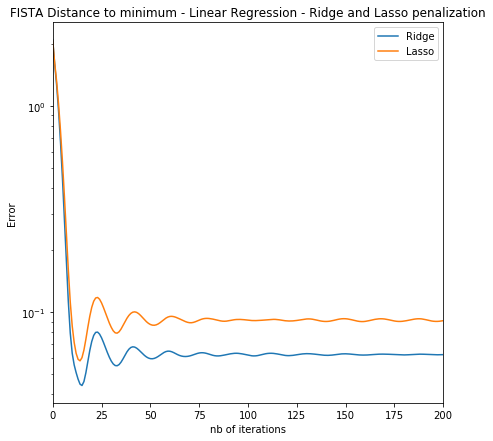

In [276]:
x_fista_ridge, objectives_fista_ridge, errors_fista_ridge, min_errors_fista_ridge = fista(
    x0=x0,f=loss_linreg,grad_f=grad_linreg,
    step=1./lip_linreg(A=A_lin),g=ridge,prox_g=prox_ridge,s=s,n_iter=n_iter,
    x_true=coefs,A=A_lin,b=b_lin, verbose=False)



x_fista_lasso, objectives_fista_lasso, errors_fista_lasso, min_errors_fista_lasso = fista(
    x0=x0,f=loss_linreg,grad_f=grad_linreg,
    step=1./lip_linreg(A=A_lin),g=lasso,prox_g=prox_lasso,s=s,n_iter=n_iter,
    x_true=coefs,A=A_lin,b=b_lin, verbose=False)


plt.figure()
plt.figure(figsize=(7,7))
plt.plot([x for x in range(n_iter+2)],[y for y in min_errors_fista_ridge],label='Ridge')
plt.xlabel('nb of iterations')
plt.ylabel('Error')
plt.plot([x for x in range(n_iter+2)],[y for y in min_errors_fista_lasso],label='Lasso')
plt.title('FISTA Distance to minimum - Linear Regression - Ridge and Lasso penalization')
plt.legend()
plt.xlim([0,200])
plt.yscale('log')


plt.show()

### Logistic regression - Lasso and Ridge comparison - when t = 1

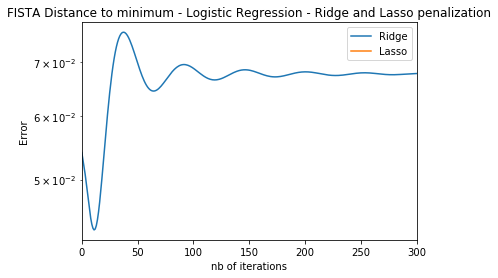

In [277]:
x_fista_ridge, objectives_fista_ridge, errors_fista_ridge, min_errors_fista_ridge = fista(
    x0=x0,f=loss_logreg,grad_f=grad_logreg,
    step=1./lip_logreg(A=A_log, b=b_log),g=ridge,prox_g=prox_ridge,s=s,n_iter=n_iter,
    x_true=coefs,A=A_log,b=b_log, verbose=False)



x_fista_lasso, objectives_fista_lasso, errors_fista_lasso, min_errors_fista_lasso = fista(
    x0=x0,f=loss_logreg,grad_f=grad_logreg,
    step=1./lip_logreg(A=A_log,b=b_log),g=lasso,prox_g=prox_lasso,s=s,n_iter=n_iter,
    x_true=coefs,A=A_log,b=b_log, verbose=False)


plt.figure()
plt.plot([x for x in range(n_iter+2)],[y for y in min_errors_fista_ridge],label='Ridge')
plt.xlabel('nb of iterations')
plt.ylabel('Error')
plt.plot([x for x in range(n_iter+2)],[y for y in min_errors_fista_lasso],label='Lasso')
plt.title('FISTA Distance to minimum - Logistic Regression - Ridge and Lasso penalization')
plt.legend()
plt.xlim([0,300])
plt.yscale('log')

plt.show()

### We notice that for both regressions, Ridge performs better, which makes sense since the proximal operator for Ridge trains more features than Lasso's (as seen in the first question)